In [16]:
import diplib as dip
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import string
from tqdm import trange


matplotlib.rcParams['font.family'] = 'STIXGeneral'
image_dir = 'images/'

# 5.1

In [27]:
def min_max_rescale(img):
    # rescale to 0..1
    return (img - np.min(img)) / (np.max(img) - np.min(img)) 


def segment_embryo(img):
    img_np = np.array(img)
    grayscale = 0.3 * img_np[:, :, 0] + 0.59 * img_np[:, :, 1] + 0.11 * img_np[:, :, 2]
    grayscale = dip.Image(grayscale)
    smoothed = dip.Gauss(grayscale, sigmas=[2.0])
    thresholded = dip.TriangleThreshold (smoothed)
    labeled = dip.Label(thresholded, connectivity=2)
    sizes = dip.MeasurementTool.Measure(labeled, features=['Size'])
    largest_label = np.argmax(sizes['Size']) + 1
    mask = labeled == largest_label
    
    return mask

def unify_images(images):
    unified_images = {}
    for key in images.keys():
        parsed_img = np.mean(images[key], axis=0)
        unified_images[key] = dip.Image(parsed_img)
    return unified_images


def convert_to_datastructure(images):
    output = []
    for img_name in images.keys():
        output.append((images[img_name], f'w8t1t2_d7_{img_name}.tif'))
    return output


def load_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    obj_pattern = r'(\d{2}).*\.tif'
    raw_images = {}
    
    for image_file in image_files:
        if 'flipped' in image_file: # discard this image
            continue
        object_name = re.search(obj_pattern, image_file).group(1)
        if object_name not in raw_images.keys():
            raw_images[object_name] = []
        img = dip.ImageReadTIFF(os.path.join(image_dir, image_file))
        img = min_max_rescale(img)
        raw_images[object_name].append(img)
    
    unified_images = unify_images(raw_images)
    images = convert_to_datastructure(unified_images)
    images.sort(key=lambda entry: entry[1])
    return images
        

def process_images(images):
    processed_images = []
    
    for (img, image_file) in images:
        mask = segment_embryo(img)
        processed_images.append((img, mask, image_file))
        
    return processed_images


def create_image_panel(images, suptitle):
    fig, axes = plt.subplots(15, 4, figsize=(8, 28))
    axes = axes.flatten()
    
    for ax, (img, title) in zip(axes, images):
        ax.imshow(np.array(img), cmap='gray')
        ax.set_title(title)
    [ax.axis('off') for ax in axes]
    plt.suptitle(suptitle, fontsize=18, y=1)
    plt.tight_layout()
    plt.show()

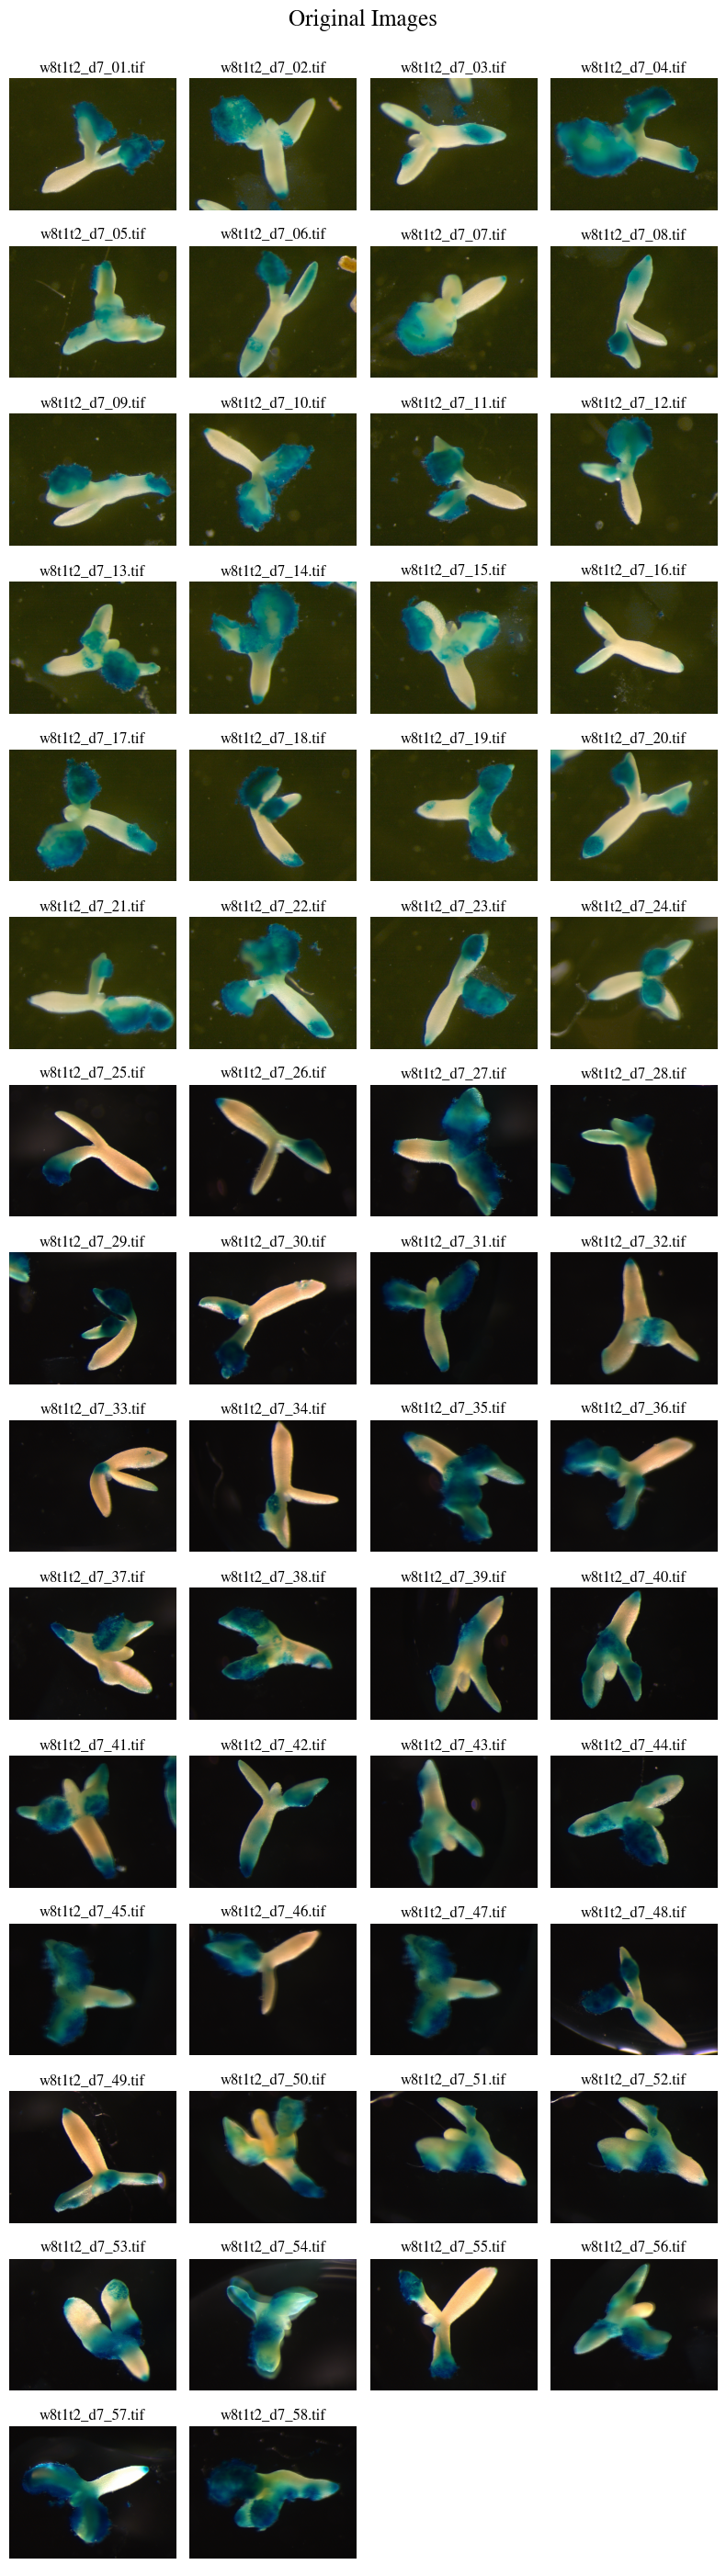

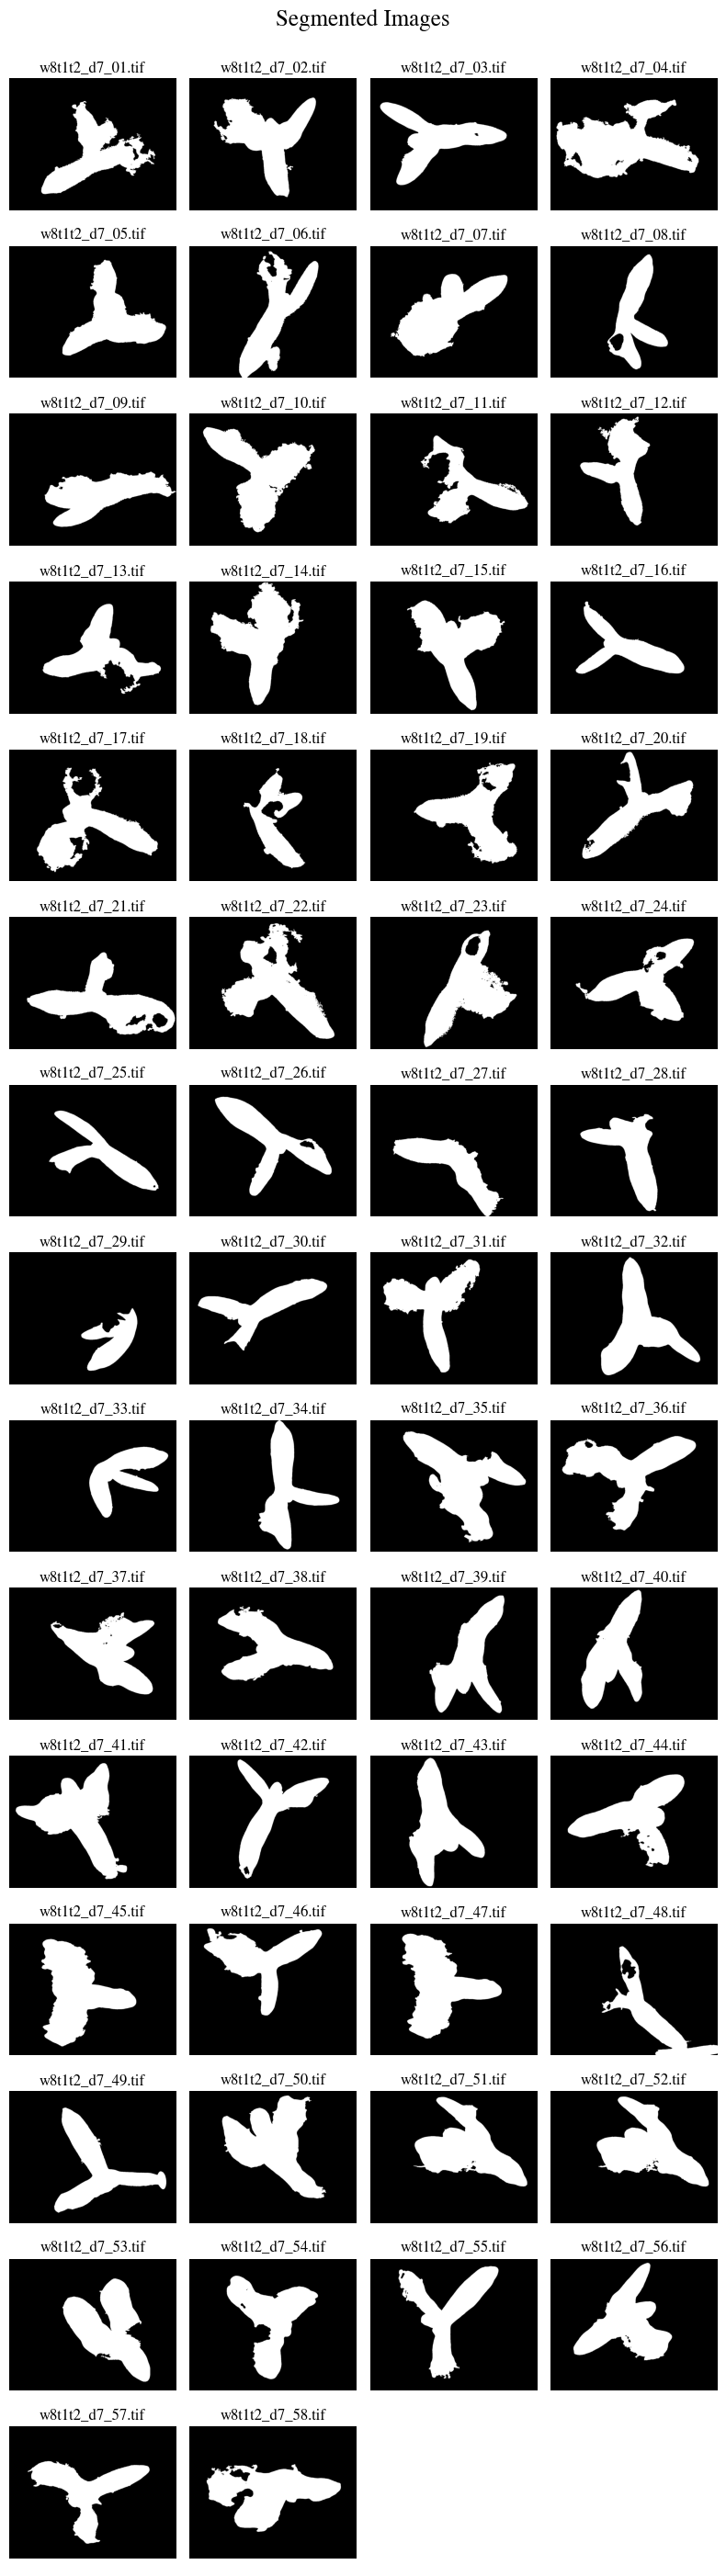

In [29]:
images = load_images(image_dir)
processed_images = process_images(images)
segmented_images = [(mask, name) for (img, mask, name) in processed_images]
segmented_images.sort(key=lambda entry: entry[1])
create_image_panel(images, 'Original Images')
create_image_panel(segmented_images, 'Segmented Images')

# 5.2

In [52]:
def measure_features(img, mask, labeled):
    area = np.sum(mask)
    measurements = dip.MeasurementTool.Measure(labeled, features=['Perimeter', 'Size', 'Feret', 'Roundness'])
    # shape_features = measurements[labeled==1]  # Assuming single labeled object
    largest_label = np.argmax(measurements['Size']) + 1

    # print (measurements['Perimeter'][largest_label])
    # print(measurements)
    # print(img.TensorElement(0))
    
    # convert to HSV, then use saturation channel to find the blue
    hsv_img = dip.ColorSpaceManager.Convert(img, 'HSV')
    saturation_channel = hsv_img.TensorElement(1)
    
    # mask the saturation channel again, so most of the embryo is excluded
    blue_threshold = 0.7 
    blue_mask = saturation_channel > blue_threshold
    
    # use both blue mask and regular mask to only measure blue size
    absolute_blue = np.sum(saturation_channel[blue_mask & mask])
    relative_blue = absolute_blue / area
    
    # print(relative_blue)
    
    # fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # axes[0].imshow(np.array(img), cmap='gray')
    # axes[0].set_title('original')
    # axes[0].axis('off')
    
    # axes[1].imshow(np.array(blue_mask), cmap='gray')
    # axes[1].set_title('blue_mask')
    # axes[1].axis('off')
    
    # # Apply mask to saturation channel
    # masked_saturation = np.array(saturation_channel) * mask
    # axes[2].imshow(masked_saturation, cmap='gray')
    # axes[2].set_title('masked saturation')
    # axes[2].axis('off')
    
    # plt.tight_layout()
    # plt.show()

    return {
        'Area': area,
        'Perimeter': measurements['Perimeter'][largest_label],
        # 'Feret': measurements['Feret'][largest_label],
        'Roundness': measurements['Roundness'][largest_label],
        'absolute_blue': absolute_blue,
        'relative_blue': relative_blue
    }

def process_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    all_features = []
    
    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        img = dip.ImageReadTIFF(img_path)
        img = img / 2 ** 16
        mask, labeled = segment_embryo(img)
        features = measure_features(img, mask, labeled)
        features['Image'] = image_file
        all_features.append(features)
        # break
    
    return all_features


image_dir = 'images/'
all_features = process_images(image_dir)
features_df = pd.DataFrame(all_features)


C:\Users\bramv\AppData\Local\Temp\ipykernel_23848\2890054421.py:43: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  saturation_channel = hsv_img.TensorElement(1)


In [53]:
features_df

Area             Perimeter              Roundness  absolute_blue  \
0   238853  [1123.2185838895953]  [0.17187008412570187]   79167.021595   
1   253154   [956.7194672229288]  [0.24341805558685256]   78194.650720   
2   212356   [798.6584422229288]    [0.292871555583179]   23178.854098   
3   365204  [1147.5991443062621]  [0.24546082991809612]  220568.475116   
4   230592    [777.545750556262]   [0.3355267598083697]   25585.679712   
..     ...                   ...                    ...            ...   
72  235106   [797.9848130562622]   [0.3247949675919429]   74665.873984   
73  241530   [820.6633088895953]  [0.31641816815628004]   76830.765176   
74  208159   [897.5446109729287]  [0.22735117920791675]  110173.175339   
75  282495  [1024.9523338895954]  [0.24157932467687218]  171136.031948   
76  280035   [958.1736172229287]   [0.2733357430517776]  170320.981879   

    relative_blue              Image  
0        0.331447   w8t1t2_d7_01.tif  
1        0.308882   w8t1t2_d7_02.tif  
2        0.109151   w8t1t2_d7_03.tif  
3        0.603960   w8t1t2_d7_04.tif  
4        0.110956   w8t1t2_d7_05.tif  
..            ...                ...  
72       0.317584   w8t1t2_d7_56.tif  
73       0.318100  w8t1t2_d7_56b.tif  
74       0.529274   w8t1t2_d7_57.tif  
75       0.605802   w8t1t2_d7_58.tif  
76       0.608213  w8t1t2_d7_58b.tif  

[77 rows x 6 columns]

In [54]:
features_df['Roundness'].apply(type)

0     <class 'list'>
1     <class 'list'>
2     <class 'list'>
3     <class 'list'>
4     <class 'list'>
           ...      
72    <class 'list'>
73    <class 'list'>
74    <class 'list'>
75    <class 'list'>
76    <class 'list'>
Name: Roundness, Length: 77, dtype: object

In [55]:
features_df['Perimeter'] = features_df['Perimeter'].apply(lambda x: x[0])
# features_df['Feret'] = features_df['Feret'].apply(lambda x: x[0])
features_df['Roundness'] = features_df['Roundness'].apply(lambda x: x[0])

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


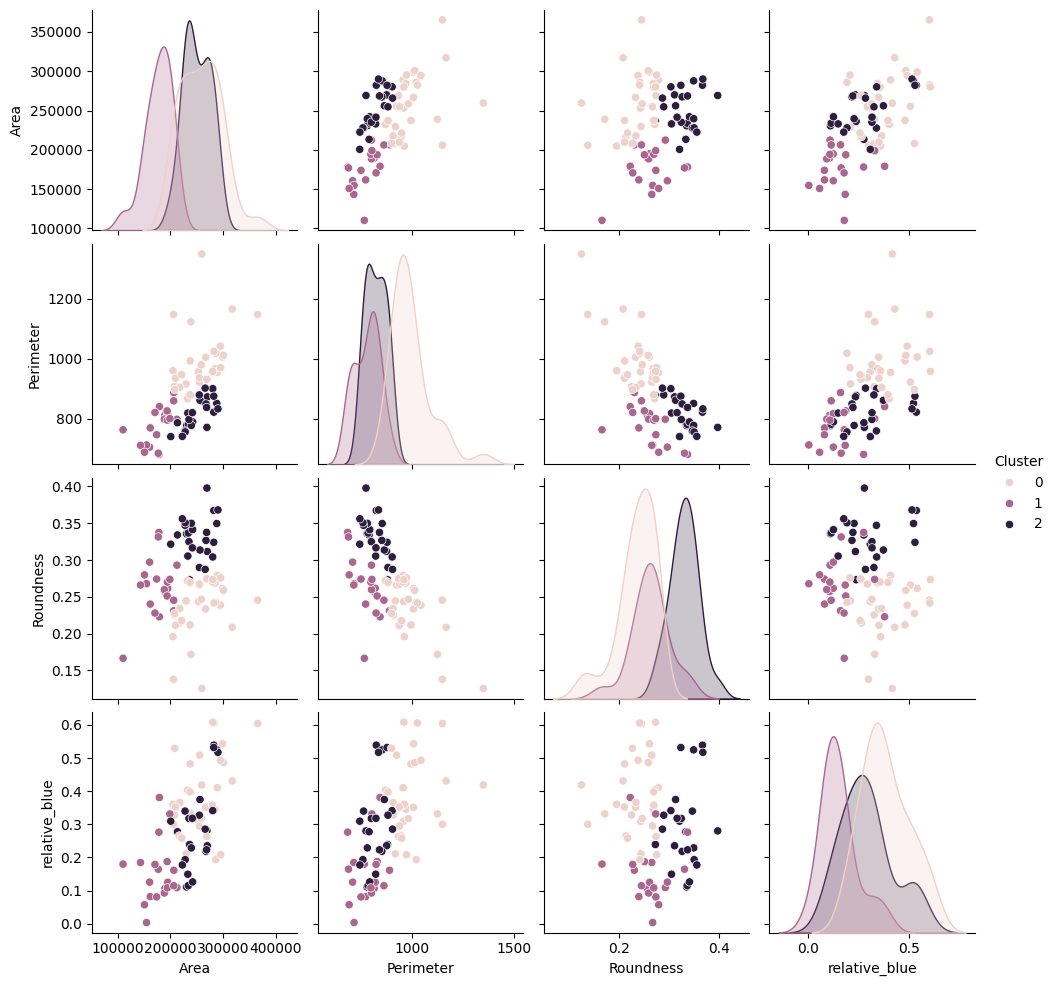

                Area   Perimeter  Roundness  relative_blue
Cluster                                                   
1        177265.5500  776.371371   0.262613       0.152516
2        250300.2400  819.600414   0.330662       0.292001
0        258023.3125  991.562124   0.236014       0.385434


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
# kmeans to find three groups in the images



# features = features_df[['Area', 'Perimeter', 'Feret', 'Roundness', 'relative_blue']]
features = features_df[['Area', 'Perimeter', 'Roundness', 'relative_blue']]

# features['Feret'] = features['Feret'].apply(lambda x: x[0])
features_df['Perimeter'] = pd.to_numeric(features_df['Perimeter'])
# features_df['Feret'] = pd.to_numeric(features_df['Feret'])
features_df['Roundness'] = pd.to_numeric(features_df['Roundness'])
features_df['RelativeBlue'] = pd.to_numeric(features_df['relative_blue'])


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
features_df['Cluster'] = kmeans.fit_predict(scaled_features)

features_df['Cluster'] = kmeans.labels_

# df = features_df[['Area', 'Perimeter', 'Feret', 'Roundness', 'relative_blue', 'Cluster']]
df = features_df[['Area', 'Perimeter', 'Roundness', 'relative_blue', 'Cluster']]
# sns.pairplot(df, hue='Cluster', diag_kind='kde', vars=['Area', 'Perimeter', 'Feret', 'Roundness', 'relative_blue'])
sns.pairplot(df, hue='Cluster', diag_kind='kde', vars=['Area', 'Perimeter', 'Roundness', 'relative_blue'])
plt.show()

cluster_summary = df.groupby('Cluster').mean()
cluster_summary = cluster_summary.sort_values(by='relative_blue', ascending=True)
print(cluster_summary)

In [57]:
thresholds = {}
for cluster in range(3):  
    cluster_data = features_df[features_df['Cluster'] == cluster]
    thresholds[cluster] = {}
    # for column in ['Area', 'Perimeter', 'Feret', 'Roundness', 'RelativeBlue']:
    for column in ['Area', 'Perimeter', 'Roundness', 'RelativeBlue']:

        thresholds[cluster][column] = {
            'min': cluster_data[column].min(),
            'max': cluster_data[column].max()
        }
        print(f"Cluster {cluster} - {column} min: {thresholds[cluster][column]['min']}, max: {thresholds[cluster][column]['max']}")


Cluster 0 - Area min: 204785, max: 365204
Cluster 0 - Perimeter min: 867.164888056262, max: 1349.1574047229287
Cluster 0 - Roundness min: 0.12545293225830773, max: 0.27907375759041786
Cluster 0 - RelativeBlue min: 0.19350457242142854, max: 0.6082131943456516
Cluster 1 - Area min: 110325, max: 212356
Cluster 1 - Perimeter min: 681.6189463895954, max: 887.5118755562621
Cluster 1 - Roundness min: 0.166470167057242, max: 0.33735418638617604
Cluster 1 - RelativeBlue min: 0.0035210023714745313, max: 0.3808780629166339
Cluster 2 - Area min: 200605, max: 290005
Cluster 2 - Perimeter min: 741.0348380562621, max: 902.377225556262
Cluster 2 - Roundness min: 0.27304535840323446, max: 0.39756474680527837
Cluster 2 - RelativeBlue min: 0.11095649333684983, max: 0.5386855051856406


# testing with tensorelements

C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\1311614499.py:6: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  red_channel = img.TensorElement(0)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\1311614499.py:7: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  green_channel = img.TensorElement(1)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\1311614499.py:8: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  blue_channel = img.TensorElement(2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


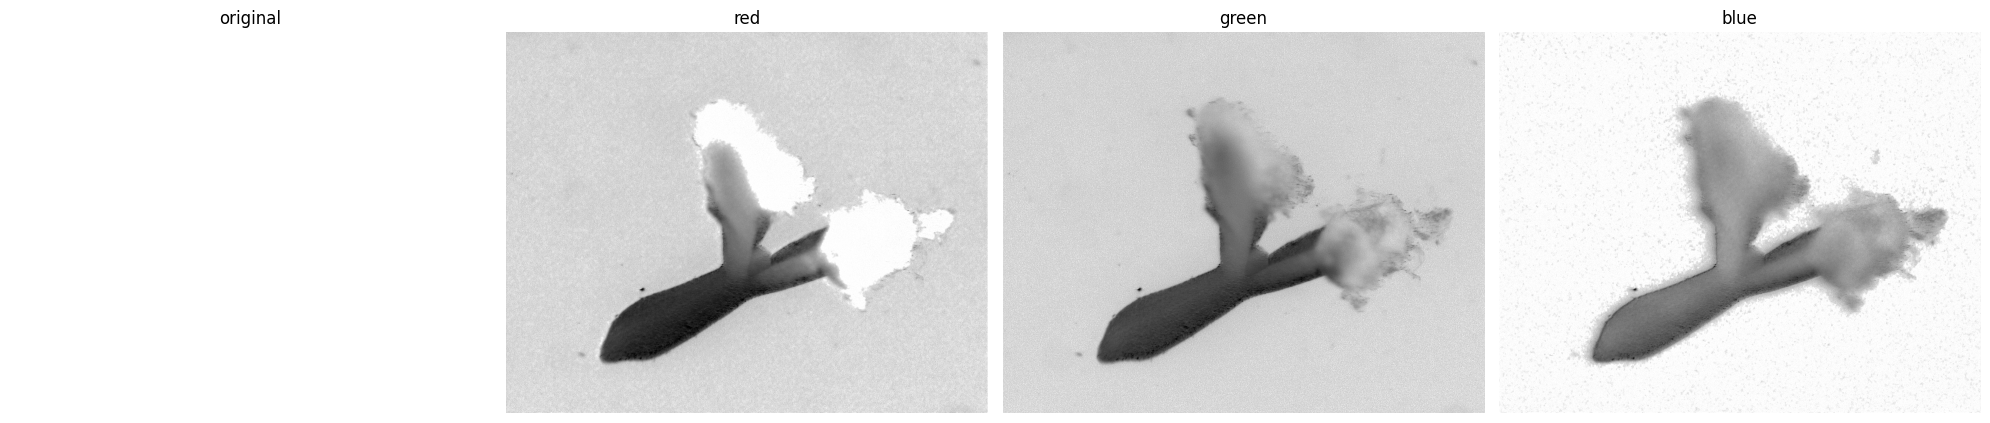

In [224]:
def plot_image_channels(image_path):
    img = dip.ImageReadTIFF(image_path)
    img = img / 2 ** 16
    img = dip.ColorSpaceManager.Convert(img, 'CMY')

    red_channel = img.TensorElement(0)
    green_channel = img.TensorElement(1)
    blue_channel = img.TensorElement(2)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(np.array(img), cmap='gray')
    axes[0].set_title('original')
    axes[0].axis('off')
    
    axes[1].imshow(np.array(red_channel), cmap='gray')
    axes[1].set_title('red')
    axes[1].axis('off')
    
    axes[2].imshow(np.array(green_channel), cmap='gray')
    axes[2].set_title('green')
    axes[2].axis('off')
    
    axes[3].imshow(np.array(blue_channel), cmap='gray')
    axes[3].set_title('blue')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

image_path = 'images/w8t1t2_d7_01.tif'
plot_image_channels(image_path)


C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\2785859745.py:7: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  hue_channel = hsv_img.TensorElement(0)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\2785859745.py:8: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  saturation_channel = hsv_img.TensorElement(1)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\2785859745.py:9: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  value_channel = hsv_img.TensorElement(2)


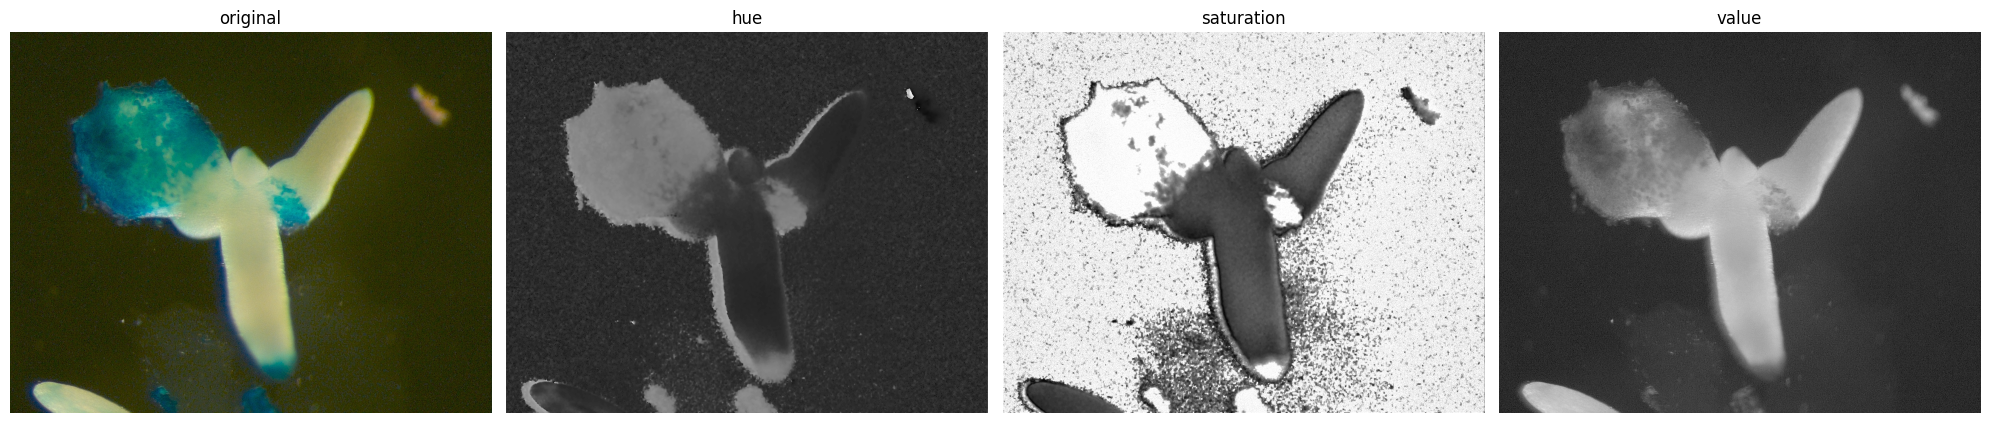

In [226]:
def plot_image_hsv_channels(image_path):
    img = dip.ImageReadTIFF(image_path)
    img = img / 2 ** 16

    hsv_img = dip.ColorSpaceManager.Convert(img, 'HSV')
    
    hue_channel = hsv_img.TensorElement(0)
    saturation_channel = hsv_img.TensorElement(1)
    value_channel = hsv_img.TensorElement(2)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(np.array(img), cmap='gray')
    axes[0].set_title('original')
    axes[0].axis('off')
    
    axes[1].imshow(np.array(hue_channel), cmap='gray')
    axes[1].set_title('hue')
    axes[1].axis('off')
    
    axes[2].imshow(np.array(saturation_channel), cmap='gray')
    axes[2].set_title('saturation')
    axes[2].axis('off')
    
    axes[3].imshow(np.array(value_channel), cmap='gray')
    axes[3].set_title('value')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

image_path = 'images/w8t1t2_d7_02.tif'
plot_image_hsv_channels(image_path)
